In [ ]:
from copy import deepcopy

import pandas as pd
from IPython.display import display, SVG
# shut off warnings
from rdkit import Chem, RDLogger
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

RDLogger.DisableLog("rdApp.*")

# Helper functions

In [ ]:
# process the results dataframe and get rid of all junk


def proc_interpret_df(df):
    orig_smis = []
    orig_scores = []
    rationale_smis = []
    rationale_scores = []

    for i, line in df.iterrows():
        line = list(line)[0]
        if (
            ("Loading pretrained" in line)
            or ("Moving model" in line)
            or ("rationale_score" in line)
            or ("Elapsed time" in line)
        ):
            continue
        line = line.split("'")
        orig_smi = line[1]
        rest = line[2].split(",")
        orig_sco = rest[1]
        rationale_smi = rest[2]
        rationale_sco = rest[3]

        orig_smis.append(orig_smi)
        orig_scores.append(orig_sco)
        rationale_smis.append(rationale_smi)
        rationale_scores.append(rationale_sco)

    newdf = pd.DataFrame()
    newdf["original_mol"] = orig_smis
    newdf["orig_score"] = orig_scores
    newdf["rationale"] = rationale_smis
    newdf["rationale_score"] = rationale_scores

    return newdf


# code adapted from https://stackoverflow.com/questions/69735586/how-to-highlight-the-substructure-of-a-molecule-with-thick-red-lines-in-rdkit-as # noqa: E501
def produce_SVG(
    smi_big,
    smi_substr,
    legend,
    file_path,
    size=(400, 200),
    kekulize=True,
):

    # first standardize both the molecule and substructure
    mol = Chem.MolFromSmiles(smi_big)
    substructure = Chem.MolFromSmiles(smi_substr)
    mol = deepcopy(mol)
    substructure = deepcopy(substructure)
    rdDepictor.Compute2DCoords(mol)
    if kekulize:
        Chem.Kekulize(mol, clearAromaticFlags=True)
        Chem.Kekulize(substructure, clearAromaticFlags=True)

        mol = Chem.RemoveHs(mol, sanitize=True)
        substructure = Chem.RemoveHs(substructure, sanitize=True)

    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])

    # highlightAtoms expects only one tuple, not tuple of tuples, so it needs to be merged into a single tuple
    matches = sum(mol.GetSubstructMatches(substructure), ())
    mod_smi = smi_big + "." + smi_substr
    if len(matches) == 0:
        if mod_smi in corrections_dict:
            matches = corrections_dict[mod_smi]
        else:
            print(smi_big)
            print(smi_substr)

    # write to the svg file
    svg = drawer.GetDrawingText()
    drawer.DrawMolecule(mol, highlightAtoms=matches, legend=legend)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()

    with open(file_path + ".svg", "w") as f:
        f.write(svg)
    return svg.replace("svg:", "")


# manually correct those that aren't being properly highlighted
corrections_dict = {
    "Cc1cc(ccc1OCCOCC[N+](C)(C)Cc1ccccc1)C(C)(C)CC(C)(C)C.C[N+:1](Cc1ccccc1)[CH3:1]": (
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
    ),
    "Cc1cc2c(c(c1C(=O)O)O)C(=O)c1c(cc(cc1C2=O)O)O.c1c2c([cH:1]c[cH:1]1)[CH2:1][CH:1]=[CH:1][CH2:1]2": (
        14,
        15,
        16,
        17,
        18,
        19,
        13,
        11,
        4,
        3,
    ),
    "CNC1=CC(=O)c2ccccc2C1=O.O=C1C=C([NH2:1])C(=O)[CH:1]=[CH:1]1": (
        1,
        2,
        3,
        4,
        5,
        6,
        11,
        12,
        13,
    ),
    "CCCCCCC[N+](CC)(CC)CCCCc1ccc(cc1)Cl.C(CC[N+:1]CCC[CH3:1])C[CH3:1]": (
        3,
        4,
        5,
        6,
        7,
        12,
        13,
        14,
        15,
        16,
    ),
    "Cc1c(cc2c(c1O)CO[C@](O)(CCCO)C2=O)O.O=C1[CH:1]=[CH:1]CO[C:1]1C[CH3:1]": (
        4,
        5,
        8,
        9,
        10,
        12,
        13,
        16,
        17,
    ),
}

# Process results and draw molecules

In [54]:
# process first round molecules
res_df = pd.read_csv(
    "../out/interpretation/interpretation_results/results_800k_mols_for_interpretation.txt",
    sep="\t",
)
df = proc_interpret_df(res_df)
meta = pd.read_csv(
    "../out/interpretation/mols_for_interpretation/800k_mols_for_interpretation.csv"
)
df["hit"] = meta["hit"]  # add in the information about if it is a true hit or not
df["round"] = ["PK_37K"] * len(df)
fulldf = df.copy()

# process second round validation molecules
res_df = pd.read_csv(
    "../out/interpretation/interpretation_results/results_molport_val1_mols_for_interpretation.txt",
    sep="\t",
)
df = proc_interpret_df(res_df)
meta = pd.read_csv(
    "../out/interpretation/mols_for_interpretation/molport_val1_mols_for_interpretation.csv"
)
df["hit"] = meta["hit"]  # add in the information about if it is a true hit or not
df["round"] = ["val1"] * len(df)
fulldf = pd.concat([fulldf, df])

# process third round validation molecules
res_df = pd.read_csv(
    "../out/interpretation/interpretation_results/results_molport_val2_val3_mols_interpretation.txt",
    sep="\t",
)
df = proc_interpret_df(res_df)
meta = pd.read_csv(
    "../out/interpretation/mols_for_interpretation/molport_val2_val3_mols_for_interpretation.csv"
)
df["hit"] = meta["hit"]  # add in the information about if it is a true hit or not
df["round"] = ["val2_val3"] * len(df)
fulldf = pd.concat([fulldf, df])
fulldf

SMILES  hit
0            [O-][N+](=O)c1ccc(s1)/C=N/NC(=O)c1ccncc1    1
1         [O-][N+](=O)c1ccc(o1)/C=C/C=C/1\SC(=S)NC1=O    1
2      Clc1ccc(c(c1)Cl)C(=O)Nc1nnc(o1)-c1cc(ccc1Cl)Cl    1
3         [O-][N+](=O)c1ccc(o1)/C=C/C=C/1\SC(=N)NC1=O    1
4        [O-][N+](=O)c1ccc(s1)C(=O)Nc1nnc(o1)-c1cccs1    1
..                                                ...  ...
89  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(c(c4c(c3C2=O)C(=O)...    1
90            [O-][N+](=O)c1cnc(s1)NC(=O)c1cccc(c1)Cl    1
91   [O-][N+](=O)c1ccc(o1)/C=N/NS(=O)(=O)c1ccc(cc1)Cl    1
92  CN(C)[C@H]1[C@@H]2C[C@@H]3[C@H](O)c4c(ccc(c4C(...    1
93                              O=C1C=CC(=O)c2ccccc21    1

[94 rows x 2 columns]

original_mol orig_score  \
0            [O-][N+](=O)c1ccc(s1)/C=N/NC(=O)c1ccncc1      0.803   
1        [O-][N+](=O)c1ccc(o1)/C=C/C=C/1\\SC(=S)NC1=O      0.758   
2      Clc1ccc(c(c1)Cl)C(=O)Nc1nnc(o1)-c1cc(ccc1Cl)Cl      0.842   
3        [O-][N+](=O)c1ccc(o1)/C=C/C=C/1\\SC(=N)NC1=O      0.763   
4        [O-][N+](=O)c1ccc(s1)C(=O)Nc1nnc(o1)-c1cccs1      0.851   
..                                                ...        ...   
93             Cc1cc(cc(c1-c1n[nH]c(c1Oc1ccccc1)C)O)O      0.397   
94                OC(=O)c1cccc(c1)Nc1nc(cs1)-c1ccccn1      0.114   
95    COC(=O)c1ccc(C[n+]2cc(-c3ccccc3)n3CCCc23)cc1.Br      0.019   
96  COc1ccc(cc1)C(=O)C[n+]1cc(-c2ccc(OC)cc2)n2CCCc...      0.025   
97  Cn1cc[n+]2C[C@@H](C(O)=O)[C@@](O)(c12)C(F)(F)F...      0.003   

                       rationale rationale_score  hit      round  
0   O=[N+]([O-])c1ccc([CH3:1])s1           0.579    1     PK_37K  
1   O=[N+]([O-])c1ccc([CH3:1])o1           0.510    1     PK_37K  
2                                                   1     PK_37K  
3   O=[N+]([O-])c1ccc([CH3:1])o1           0.510    1     PK_37K  
4   O=[N+]([O-])c1ccc([CH3:1])s1           0.579    1     PK_37K  
..                           ...             ...  ...        ...  
93    Oc1cc(O)c([CH3:1])[cH:1]c1           0.179    0  val2_val3  
94                                                  0  val2_val3  
95                                                  0  val2_val3  
96                                                  0  val2_val3  
97                                                  0  val2_val3  

[250 rows x 6 columns]


-----------------------------------------------------------------------
actual hit:  1


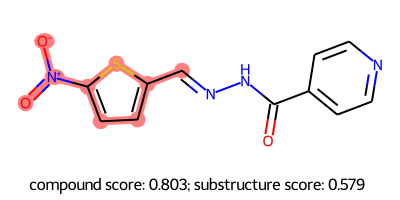


-----------------------------------------------------------------------
actual hit:  1


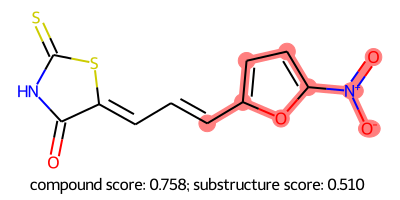


-----------------------------------------------------------------------
actual hit:  1


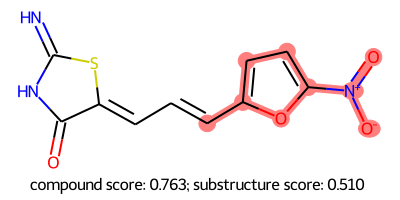


-----------------------------------------------------------------------
actual hit:  1


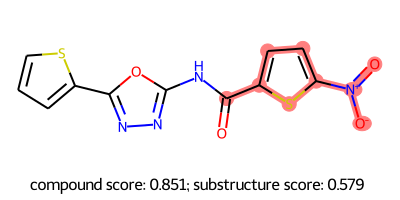


-----------------------------------------------------------------------
actual hit:  1


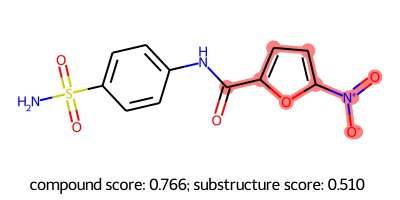


-----------------------------------------------------------------------
actual hit:  1


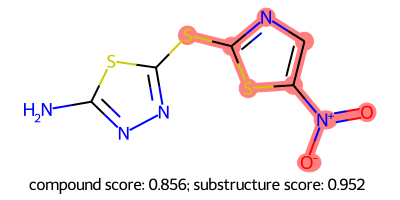


-----------------------------------------------------------------------
actual hit:  1


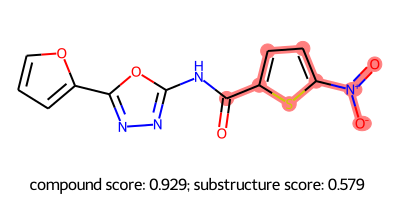


-----------------------------------------------------------------------
actual hit:  1


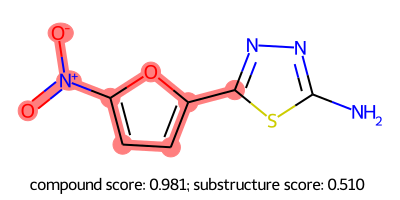


-----------------------------------------------------------------------
actual hit:  1


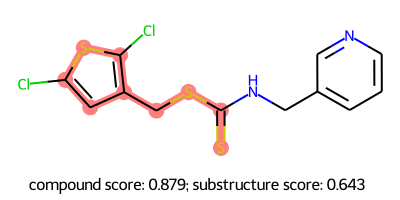


-----------------------------------------------------------------------
actual hit:  1


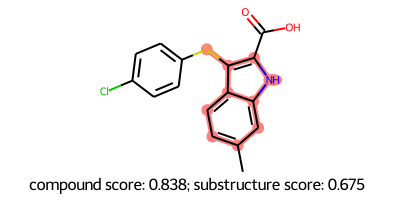


-----------------------------------------------------------------------
actual hit:  1


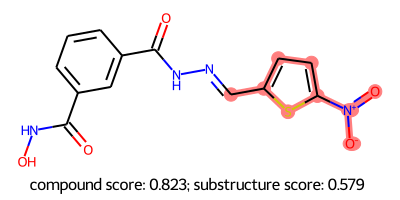


-----------------------------------------------------------------------
actual hit:  0


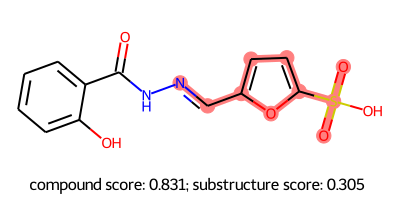


-----------------------------------------------------------------------
actual hit:  0


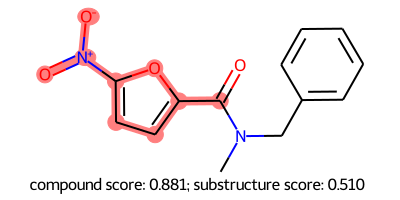


-----------------------------------------------------------------------
actual hit:  0


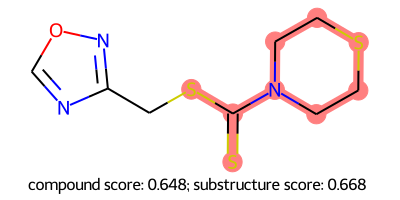


-----------------------------------------------------------------------
actual hit:  0


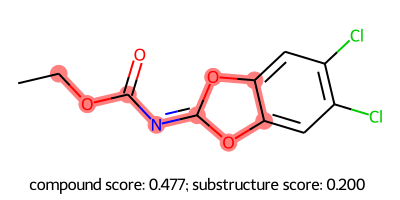


-----------------------------------------------------------------------
actual hit:  0


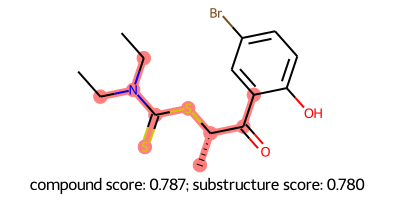


-----------------------------------------------------------------------
actual hit:  0


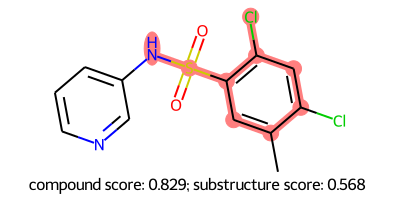


-----------------------------------------------------------------------
actual hit:  0


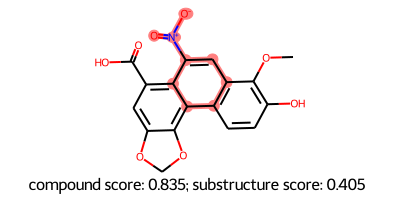


-----------------------------------------------------------------------
actual hit:  0


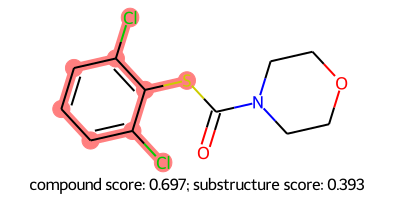


-----------------------------------------------------------------------
actual hit:  0


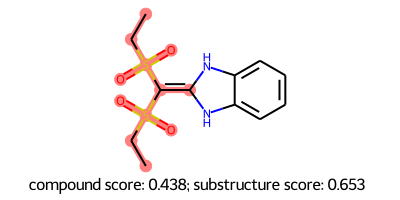


-----------------------------------------------------------------------
actual hit:  0


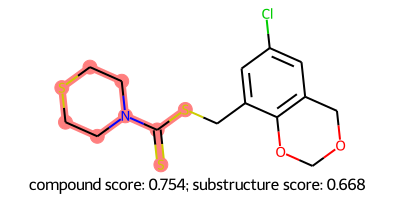


-----------------------------------------------------------------------
actual hit:  0


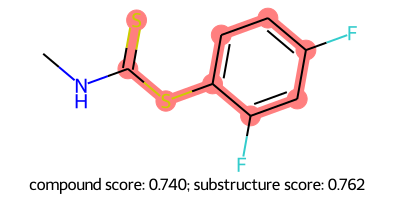


-----------------------------------------------------------------------
actual hit:  0


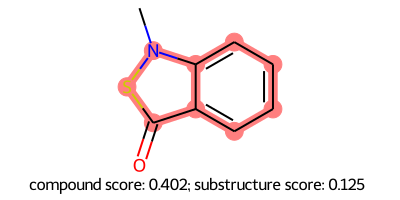


-----------------------------------------------------------------------
actual hit:  0


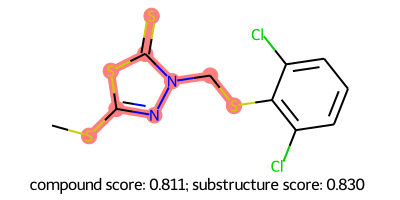


-----------------------------------------------------------------------
actual hit:  0


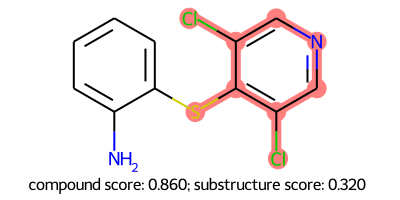


-----------------------------------------------------------------------
actual hit:  0


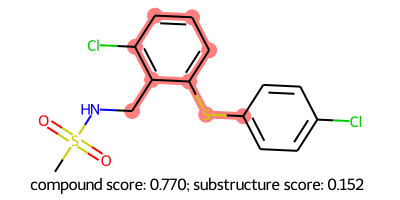


-----------------------------------------------------------------------
actual hit:  0


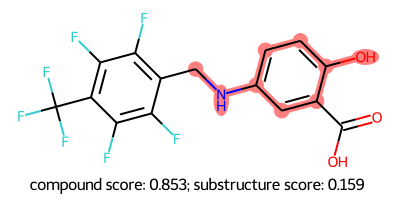


-----------------------------------------------------------------------
actual hit:  0


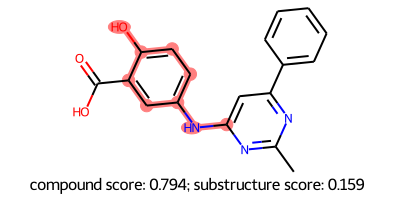


-----------------------------------------------------------------------
actual hit:  0


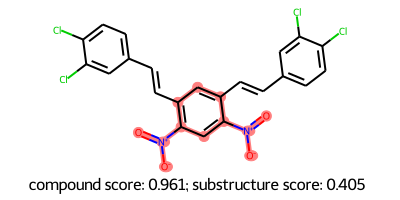


-----------------------------------------------------------------------
actual hit:  0


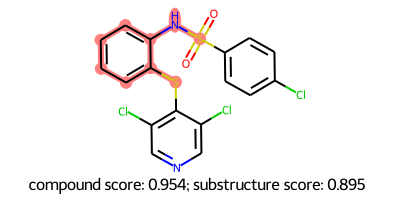


-----------------------------------------------------------------------
actual hit:  0


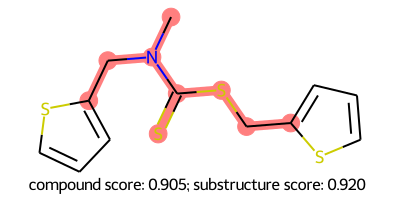


-----------------------------------------------------------------------
actual hit:  0


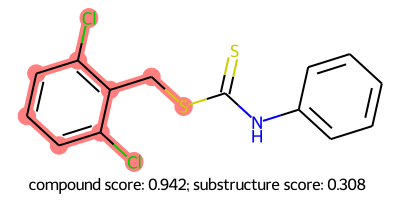


-----------------------------------------------------------------------
actual hit:  0


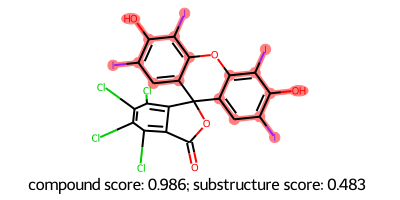


-----------------------------------------------------------------------
actual hit:  0


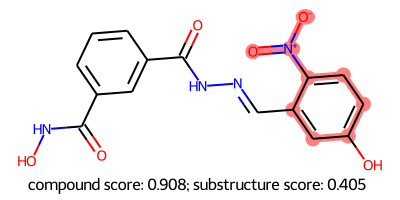


-----------------------------------------------------------------------
actual hit:  0


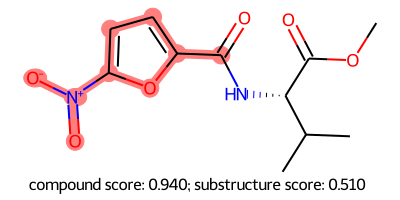


-----------------------------------------------------------------------
actual hit:  0


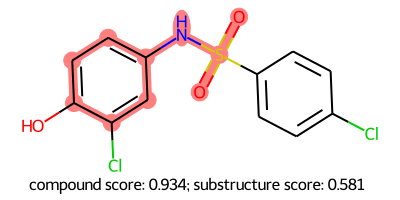


-----------------------------------------------------------------------
actual hit:  0


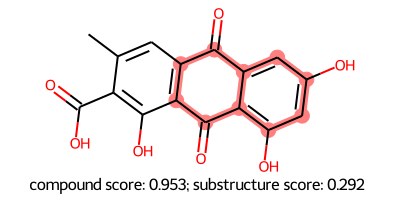


-----------------------------------------------------------------------
actual hit:  1


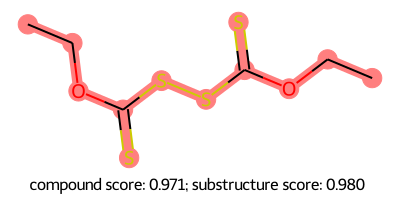


-----------------------------------------------------------------------
actual hit:  1


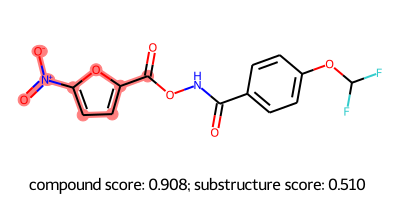


-----------------------------------------------------------------------
actual hit:  1


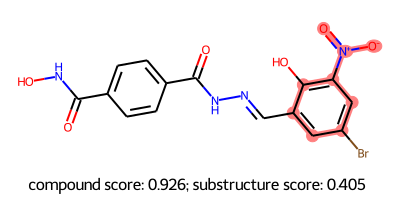


-----------------------------------------------------------------------
actual hit:  1


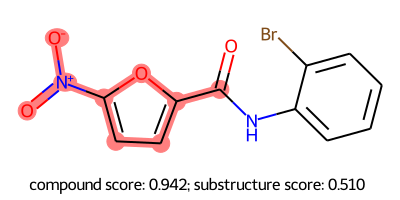


-----------------------------------------------------------------------
actual hit:  1


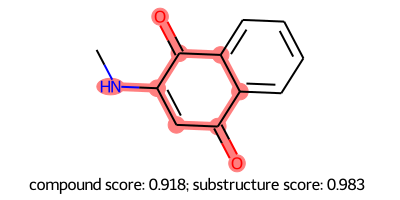


-----------------------------------------------------------------------
actual hit:  1


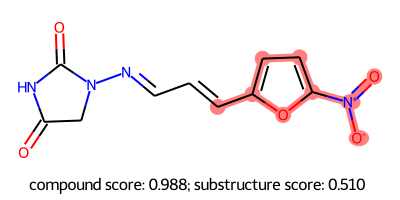


-----------------------------------------------------------------------
actual hit:  1


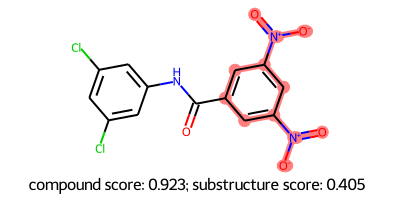


-----------------------------------------------------------------------
actual hit:  1


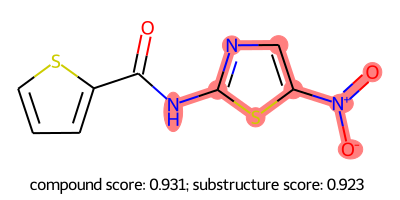


-----------------------------------------------------------------------
actual hit:  1


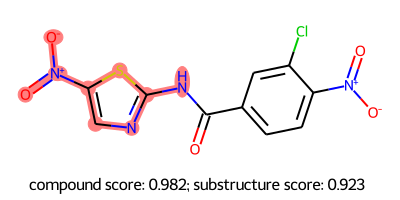


-----------------------------------------------------------------------
actual hit:  1


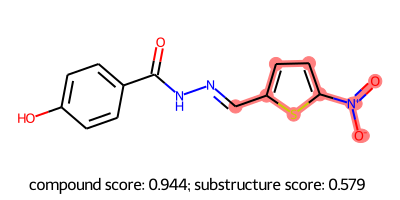


-----------------------------------------------------------------------
actual hit:  1


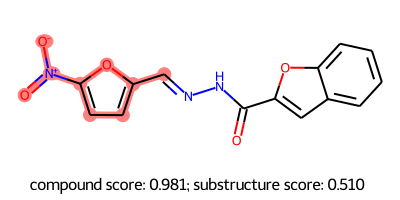


-----------------------------------------------------------------------
actual hit:  1


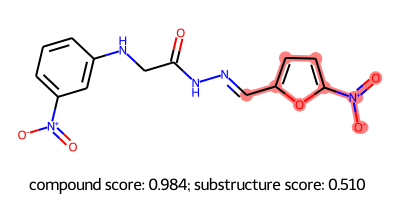


-----------------------------------------------------------------------
actual hit:  1


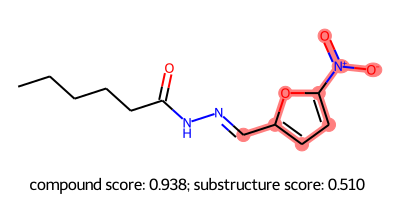


-----------------------------------------------------------------------
actual hit:  1


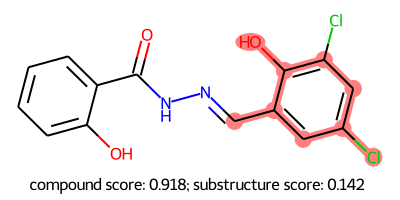


-----------------------------------------------------------------------
actual hit:  1


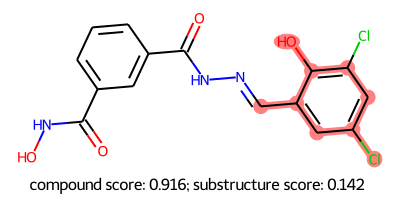


-----------------------------------------------------------------------
actual hit:  1


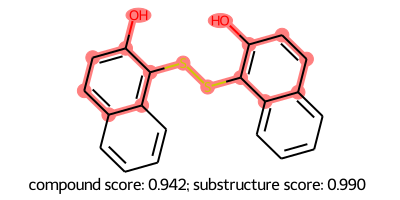


-----------------------------------------------------------------------
actual hit:  1


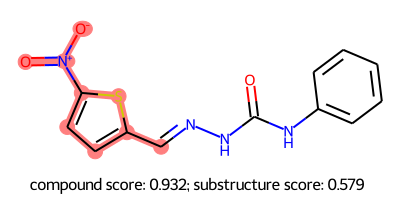


-----------------------------------------------------------------------
actual hit:  1


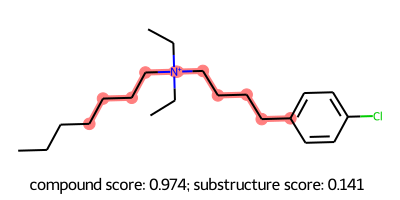


-----------------------------------------------------------------------
actual hit:  1


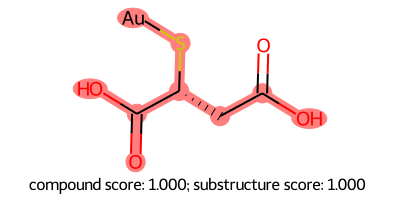


-----------------------------------------------------------------------
actual hit:  1


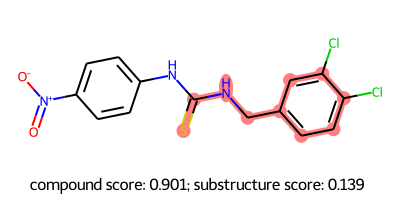


-----------------------------------------------------------------------
actual hit:  1


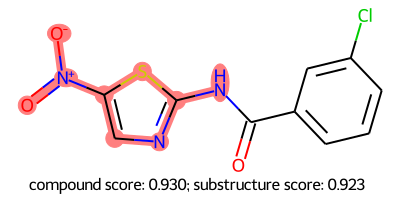


-----------------------------------------------------------------------
actual hit:  1


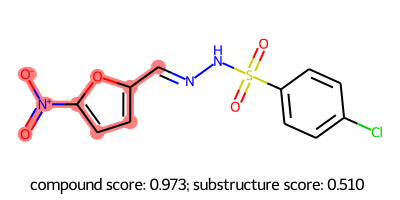


-----------------------------------------------------------------------
actual hit:  1


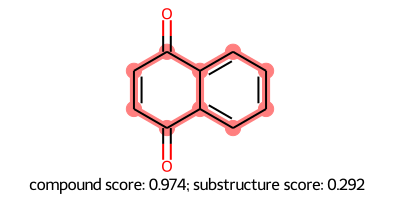


-----------------------------------------------------------------------
actual hit:  1


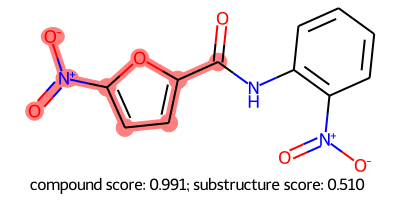


-----------------------------------------------------------------------
actual hit:  0


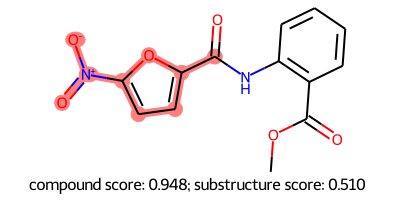


-----------------------------------------------------------------------
actual hit:  1


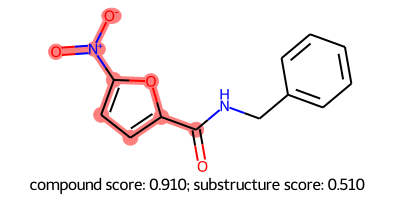


-----------------------------------------------------------------------
actual hit:  1


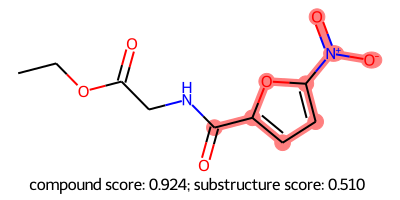


-----------------------------------------------------------------------
actual hit:  0


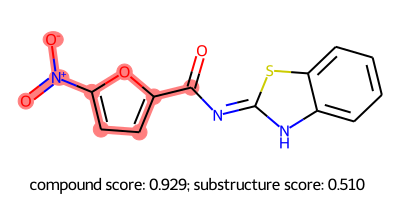


-----------------------------------------------------------------------
actual hit:  0


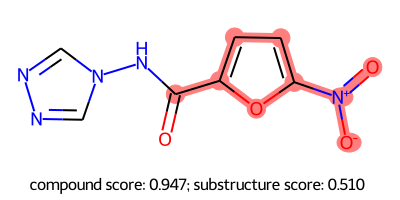


-----------------------------------------------------------------------
actual hit:  1


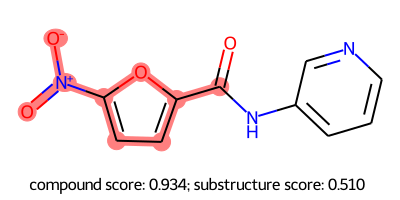


-----------------------------------------------------------------------
actual hit:  0


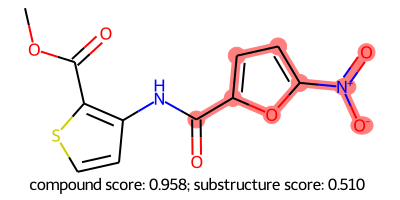


-----------------------------------------------------------------------
actual hit:  0


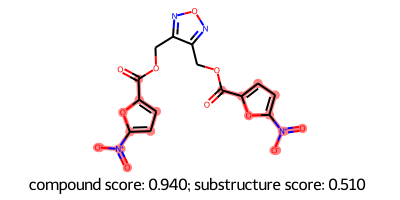


-----------------------------------------------------------------------
actual hit:  1


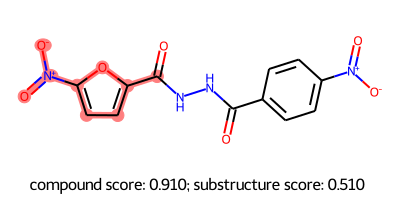


-----------------------------------------------------------------------
actual hit:  1


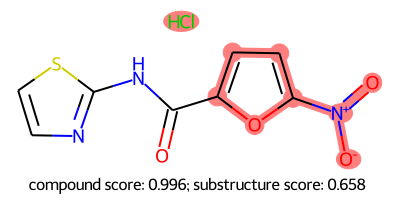


-----------------------------------------------------------------------
actual hit:  0


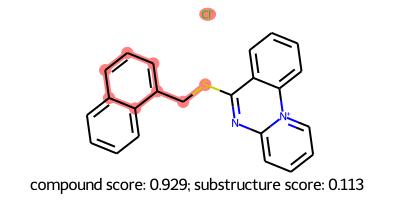


-----------------------------------------------------------------------
actual hit:  0


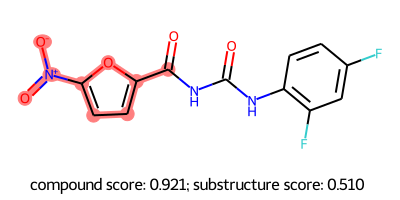


-----------------------------------------------------------------------
actual hit:  1


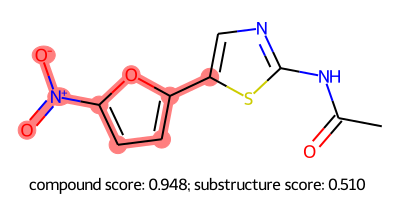


-----------------------------------------------------------------------
actual hit:  1


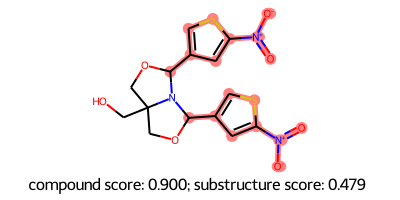


-----------------------------------------------------------------------
actual hit:  1


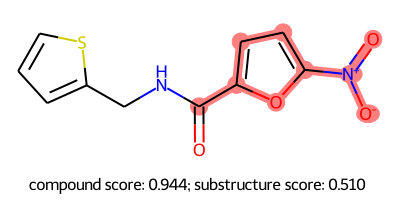


-----------------------------------------------------------------------
actual hit:  1


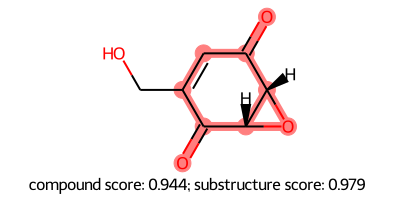


-----------------------------------------------------------------------
actual hit:  1


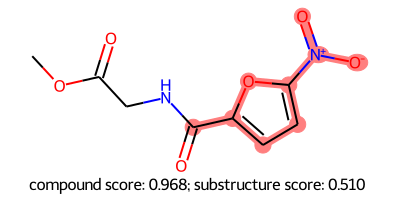


-----------------------------------------------------------------------
actual hit:  1


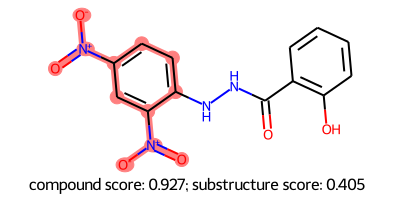


-----------------------------------------------------------------------
actual hit:  1


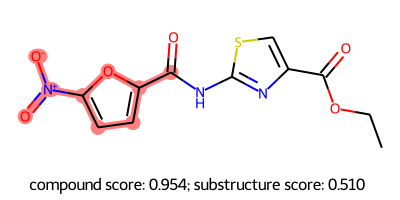


-----------------------------------------------------------------------
actual hit:  0


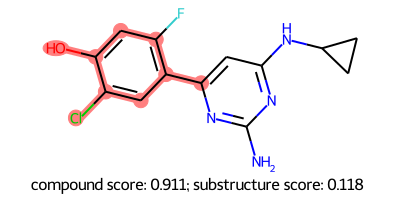


-----------------------------------------------------------------------
actual hit:  1


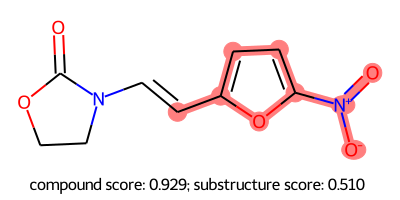


-----------------------------------------------------------------------
actual hit:  1


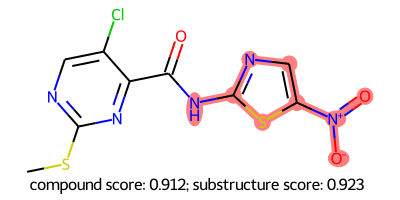


-----------------------------------------------------------------------
actual hit:  0


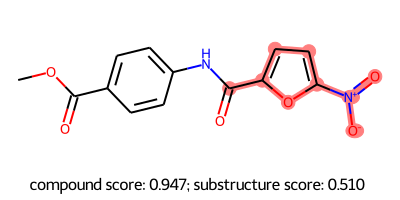


-----------------------------------------------------------------------
actual hit:  1


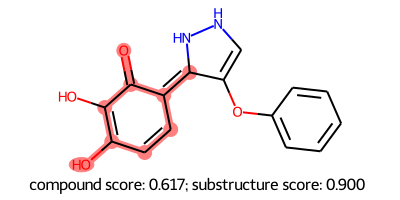


-----------------------------------------------------------------------
actual hit:  1


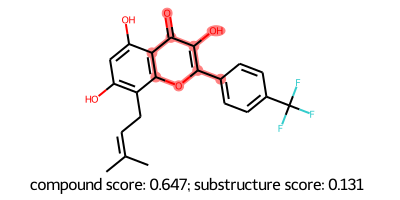


-----------------------------------------------------------------------
actual hit:  1


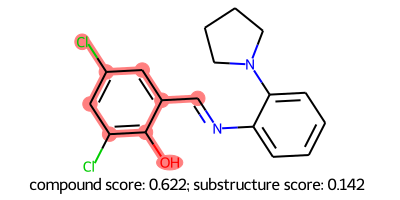


-----------------------------------------------------------------------
actual hit:  0


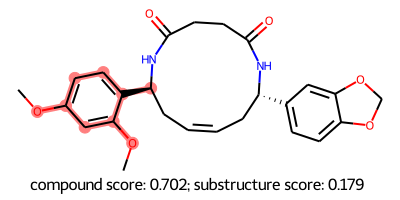


-----------------------------------------------------------------------
actual hit:  0


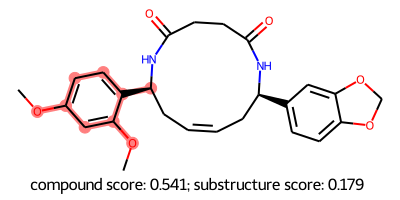


-----------------------------------------------------------------------
actual hit:  0


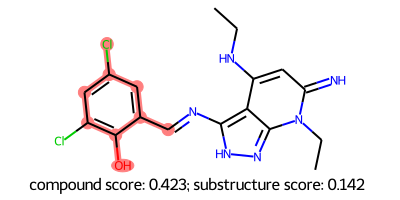


-----------------------------------------------------------------------
actual hit:  0


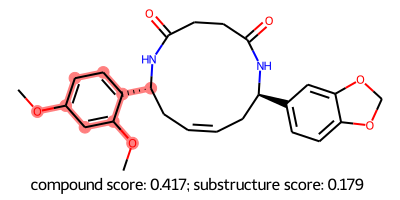


-----------------------------------------------------------------------
actual hit:  0


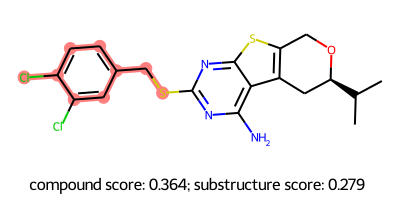


-----------------------------------------------------------------------
actual hit:  0


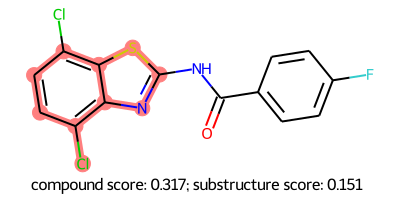


-----------------------------------------------------------------------
actual hit:  0


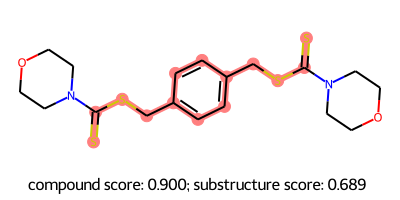


-----------------------------------------------------------------------
actual hit:  0


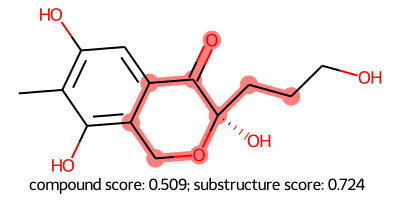


-----------------------------------------------------------------------
actual hit:  0


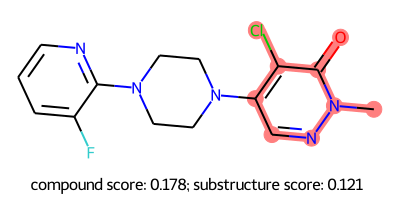


-----------------------------------------------------------------------
actual hit:  0


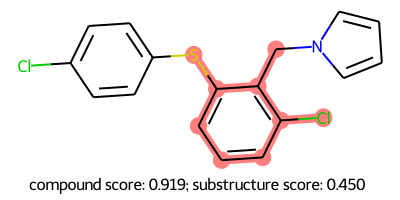


-----------------------------------------------------------------------
actual hit:  0


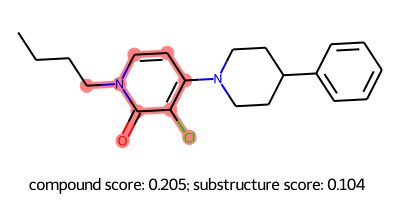


-----------------------------------------------------------------------
actual hit:  0


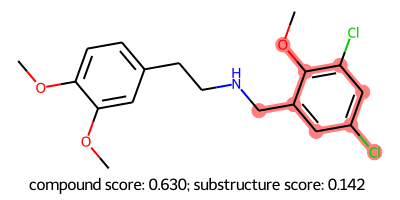


-----------------------------------------------------------------------
actual hit:  0


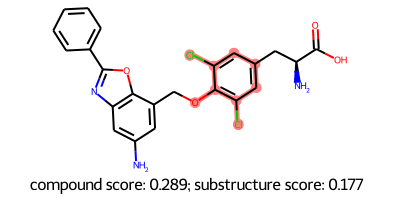


-----------------------------------------------------------------------
actual hit:  0


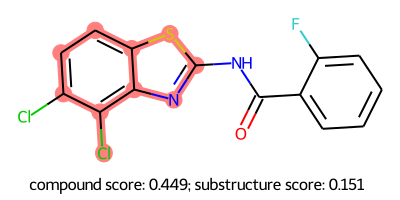


-----------------------------------------------------------------------
actual hit:  0


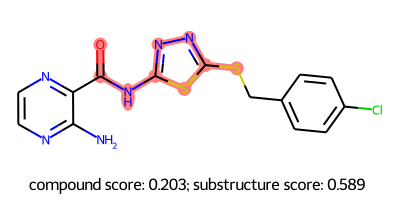


-----------------------------------------------------------------------
actual hit:  1


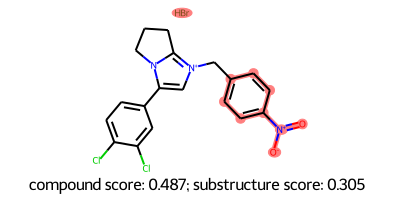


-----------------------------------------------------------------------
actual hit:  1


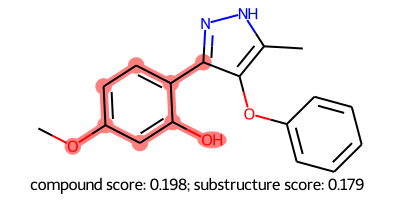


-----------------------------------------------------------------------
actual hit:  1


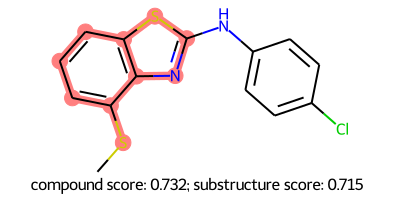


-----------------------------------------------------------------------
actual hit:  0


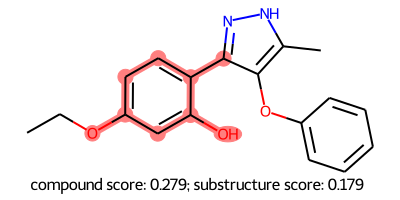


-----------------------------------------------------------------------
actual hit:  0


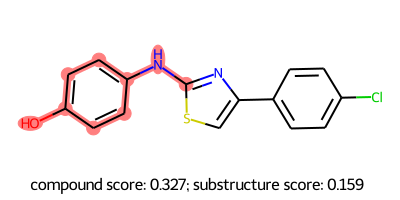


-----------------------------------------------------------------------
actual hit:  0


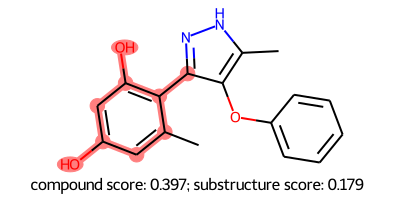

In [52]:
out_path = "../out/interpretation/interpretation_images/"

for i, line in fulldf.iterrows():

    actual_inh = line["hit"]

    orig_smi = line["original_mol"]
    orig_sco = line["orig_score"]
    rat_smi = line["rationale"]
    rat_sco = line["rationale_score"]
    round = line["round"]

    if rat_sco != "":
        print("")
        print("-----------------------------------------------------------------------")
        print("actual hit: ", actual_inh)
        clean_smi = orig_smi.replace(
            "/", ""
        )  # having a problem with saving due to escape characters - modify only for filepath
        img = SVG(
            produce_SVG(
                orig_smi,
                rat_smi,
                legend="compound score: "
                + str(orig_sco)
                + "; substructure score: "
                + str(rat_sco),
                file_path=out_path + round + "_" + clean_smi,
            )
        )
        display(img)

In [53]:
fulldf.to_csv(out_path + "full_rationale_results.csv", index=False)